In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [6]:
!pip install patchify

In [7]:
import torch
import torchvision
from torchvision.models import vit_b_16, ViT_B_16_Weights, get_model
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import time
from torchvision import datasets
import os
from patchify import patchify, unpatchify
import numpy as np
import tensorflow as tf
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor, ViTModel
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset, random_split
import timm
matplotlib.style.use('ggplot')

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [9]:
transform = transforms.Compose([transforms.Resize(384),
                                transforms.ToTensor()
                                ])

In [ ]:
batch_size = 8
fake_dir = '/content/drive/MyDrive/Datasets/FF++/Sample Dataset/C23/Manipulated/DeepFake'
real_dir = '/content/drive/MyDrive/Datasets/FF++/Sample Dataset/C23/Original/Original'

class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.files = [os.path.join(path, f) for f in os.listdir(path)]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        image = Image.open(file)
        label = 0 if "Original" in file else 1
        if self.transform:
            image = self.transform(image)
        return image, label

custom_fake_dataset = CustomImageDataset(fake_dir, transform=transform)

total_samples = len(custom_fake_dataset)
train_size = 2938 #int(0.7 * total_samples)
val_size = 200 #int(0.2 * total_samples)
test_size = 100 #total_samples - train_size - val_size
rem_size =  total_samples - train_size - val_size - test_size

fake_train_subset, fake_val_subset, fake_test_subset, _ = random_split(
    custom_fake_dataset, [train_size, val_size, test_size, rem_size]
)

custom_real_dataset = CustomImageDataset(real_dir, transform=transform)

total_samples = len(custom_real_dataset)
train_size = 2938 # int(0.7 * total_samples)
val_size = 200 # int(0.2 * total_samples)
test_size = 100 # total_samples - train_size - val_size
rem_size =  total_samples - train_size - val_size - test_size

real_train_subset, real_val_subset, real_test_subset, _ = random_split(
    custom_real_dataset, [train_size, val_size, test_size, rem_size]
)

train_dataset = torch.utils.data.ConcatDataset([fake_train_subset, real_train_subset])
val_dataset = torch.utils.data.ConcatDataset([fake_val_subset, real_val_subset])
test_dataset = torch.utils.data.ConcatDataset([fake_test_subset, real_test_subset])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             shuffle=False)

In [ ]:
print("Train Loader Length", len(train_dataset))
print("Validation Loader Length", len(val_dataset))
print("Test Loader Length", len(test_dataset))

Train Loader Length 5876
Validation Loader Length 400
Test Loader Length 200


Feature batch shape: torch.Size([8, 3, 384, 384])
Labels batch shape: torch.Size([8])


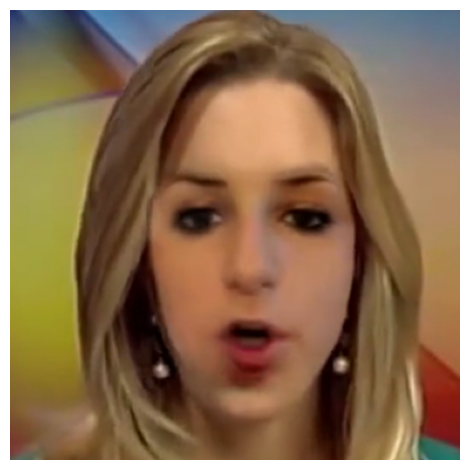

Label: 1


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.show()
print(f"Label: {label}")

In [ ]:
class Xception(nn.Module):
  def __init__(self):
        super(Xception, self).__init__()
        # self.xception_model = tf.keras.applications.xception.Xception(
        #     include_top=False,
        #     weights='imagenet',
        #     input_shape = (384, 384, 3)
        # )
        # self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.global_avg_pool = nn.AvgPool2d(12, 12)
        self.xception_model = timm.create_model('xception', pretrained=True)

  def forward(self, input):
        # x = input.permute(0, 2, 3, 1)
        # x = tf.keras.applications.xception.preprocess_input(x)
        # output = self.xception_model(x.numpy())
        # output = self.global_avg_pool(output.numpy())
        # return output.numpy()
        output = self.xception_model.forward_features(input)
        output = self.global_avg_pool(output)
        return output

In [ ]:
train_features.shape

torch.Size([8, 3, 384, 384])

In [ ]:
outx = Xception()(train_features)

In [ ]:
print(outx.shape)
print(type(outx))

In [168]:
img = img.unsqueeze(0)

In [169]:
# img = img.permute(0, 3, 1, 2)

In [170]:
img.shape

torch.Size([1, 384, 384, 3])

In [171]:
patch_size = 16
stride = 16
img = img.permute(0, 3, 1, 2)
patches = img.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
# Reshape patches for further processing
# patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(-1, 3, patch_size, patch_size)
patches = patches.permute(0, 2, 3, 1, 4, 5).squeeze(axis=0)

In [172]:
count = 0
for i in patches:
  # print(i.shape)
  count = count + 1
print(count)

24


In [173]:
patches.shape

torch.Size([24, 24, 3, 16, 16])

tensor(0.1176) tensor(0.0275)
tensor(1.) tensor(0.2333)


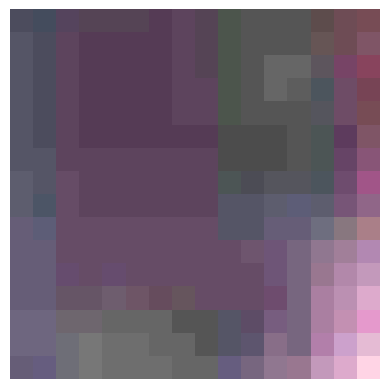

In [174]:
d = patches[5][5].permute(1, 2, 0)
print(torch.max(d), torch.min(d))
d = d / torch.max(d)
print(torch.max(d), torch.min(d))
plt.imshow(d)
plt.axis('off')
plt.show()

In [175]:
class PatchModule(nn.Module):
  def __init__(self):
    super(PatchModule, self).__init__()
    self.conv = nn.ModuleList([
            nn.ModuleList([
                nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
                for j in range(24)
            ])
            for i in range(24)
        ])

  def extract_patches(self, img):
    patch_size = 16
    stride = 16
    patches = img.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    patches = patches.permute(2, 3, 0, 1, 4, 5).squeeze(axis=0)
    return patches

  def forward(self, x):
    patches = self.extract_patches(x)
    conv_patches = torch.zeros(24, 24, x.size(0), 3, 16, 16, device=x.device)
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        for batch_idx in range(patches.shape[2]):
          conv_patches[i][j][batch_idx] = self.conv[i][j](patches[i][j][batch_idx])
    patches = patches / (torch.max(patches) + 1e-6)
    conv_patches = conv_patches / (torch.max(conv_patches) + 1e-6)
    output_image = patches * conv_patches
    output_image = output_image / (torch.max(output_image) + 1e-6)
    return output_image

In [176]:
pm = PatchModule().to(device)

In [177]:
pm

PatchModule(
  (conv): ModuleList(
    (0-23): 24 x ModuleList(
      (0-23): 24 x Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [178]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(pm)

Total Trainable Params: 48384


48384

In [179]:
outp = pm(train_features)

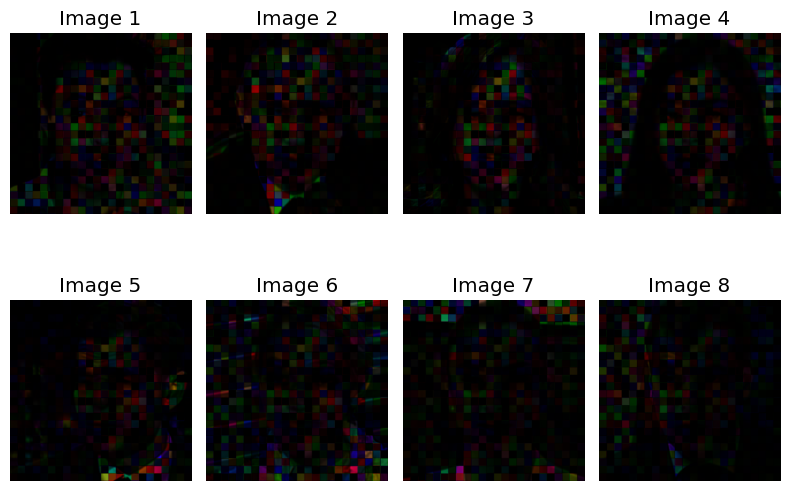

In [180]:
import torch
import matplotlib.pyplot as plt

# Create a sample tensor with the given shape
tensor = outp

# Permute the tensor to bring batch and channel to the front
tensor = tensor.permute(2, 3, 0, 4, 1, 5)  # [batch, channel, patch_dim1, height, patch_dim2, width]

# Reshape to combine patches into full images
batch_size, channels, patch_dim1, height, patch_dim2, width = tensor.shape
combined_images = tensor.reshape(batch_size, channels, patch_dim1 * height, patch_dim2 * width)

# Display the images
def show_images(images, custom_width=2, custom_height=2):
    batch_size, channels, height, width = images.shape
    rows, cols = 2, 4  # Two rows, four columns
    fig, axes = plt.subplots(rows, cols, figsize=(8, 6))  # Set custom figure size

    for i in range(rows):
        for j in range(cols):
            img = images[i * cols + j].permute(1, 2, 0).detach().numpy()  # [C, H, W] to [H, W, C]
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"Image {i * cols + j + 1}")
            axes[i, j].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Show the combined images
show_images(combined_images)


In [48]:
class VIT_Encoder(nn.Module):
  def __init__(self):
    super(VIT_Encoder, self).__init__()
    # self.processor = ViTImageProcessor().from_pretrained('google/vit-base-patch16-384')
    # self.vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-384')
    self.vit_model = timm.create_model('vit_small_patch16_384.augreg_in1k', pretrained=True)

  def forward(self, x):
    # tensor = x
    # # Permute the tensor to bring batch and channel to the front
    # tensor = tensor.permute(2, 3, 0, 4, 1, 5)  # [batch, channel, patch_dim1, height, patch_dim2, width]
    # # Reshape to combine patches inNto full images
    # batch_size, channels, patch_dim1, height, patch_dim2, width = tensor.shape
    # x = tensor.reshape(batch_size, channels, patch_dim1 * height, patch_dim2 * width)

    # x = x - torch.min(x)
    # x = x/torch.max(x)
    # inputs = self.processor(images=x, return_tensors="pt")
    # outputs = self.vit_model(**inputs)
    # logits = outputs.logits
    # return logits

    output = self.vit_model.forward_features(x)
    return output

In [49]:
model = VIT_Encoder()

model.safetensors:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

In [50]:
output = model(train_features)

In [52]:
output.shape

torch.Size([8, 577, 384])

In [54]:
flat = torch.flatten(output, 1, 2)

In [55]:
flat.shape

torch.Size([8, 221568])

In [ ]:
timm.list_models("vit*", pretrained=True)

In [27]:
class Classification_Module(nn.Module):
  def __init__(self):
    super(Classification_Module, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(3048, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
    )

  def forward(self, input):
    return self.model(input)

In [28]:
class ViXNet(nn.Module):
    def __init__(self):
      super(ViXNet, self).__init__()
      self.patch_module = PatchModule()
      self.vit_encoder = VIT_Encoder()
      self.xception = Xception()
      self.classification = Classification_Module()

    def forward(self, x):
      patch_module_output = self.patch_module(x)
      vit_output = self.vit_encoder(patch_module_output)
      xception_output = self.xception(x)
      output = torch.cat((
          vit_output,
          torch.tensor(xception_output)
          ), dim=1)

      output = self.classification(output)
      return output

In [29]:
model = ViXNet().to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

ViXNet(
  (patch_module): PatchModule(
    (conv): ModuleList(
      (0-23): 24 x ModuleList(
        (0-23): 24 x Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (vit_encoder): VIT_Encoder(
    (vit_model): ViTForImageClassification(
      (vit): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViTLayer(
              (attention): ViTSdpaAttention(
                (attention): ViTSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropou

In [30]:
out = model(img)
print(out)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


tensor([[0.0606]], grad_fn=<AddmmBackward0>)


In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [79]:
def train(model, trainloader, optimizer, loss_fn):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = loss_fn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [80]:
# validation Of Model
def validate(model, testloader, loss_fn):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [82]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Author ran for 50 Epochs
epochs = 1
since = time.time()
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                              optimizer, loss_fn)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,
                                                 loss_fn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

[INFO]: Epoch 1 of 1
Training


  0%|          | 0/735 [00:00<?, ?it/s]

IndexError: Target 1 is out of bounds.

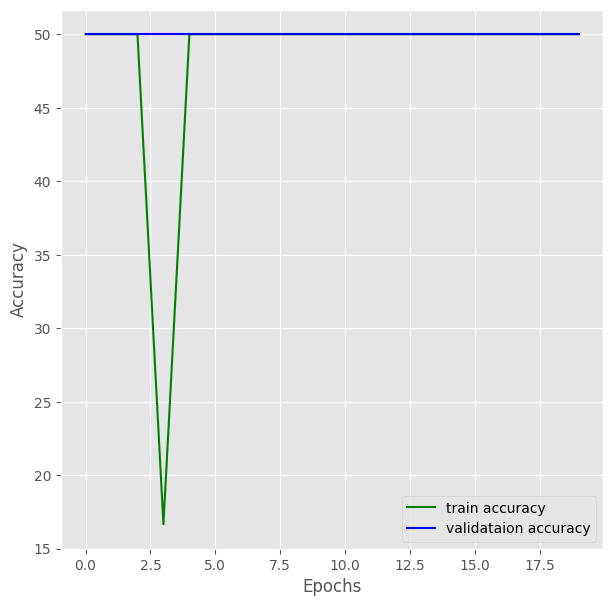

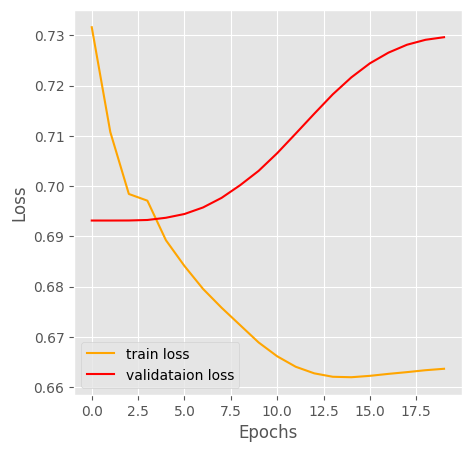

MODEL SAVED...


In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(
    train_acc, color='green', linestyle='-',
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-',
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/accuracytl.png')
plt.show()
# loss plots
plt.figure(figsize=(5, 5))
plt.plot(
    train_loss, color='orange', linestyle='-',
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-',
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/losstl.png')
plt.show()
# save the final model
save_path = 'model_res.pth'
torch.save(model.state_dict(), save_path)
print('MODEL SAVED...')